In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt
import math

/tmp/ipykernel_2506548/1518451047.py:8: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("ignore", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [3]:
with open('../../filelists/hgg_files.txt', 'r') as f:
    hgg_files = [line.strip() for line in f]

In [4]:
hgg = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/signal/hgg/' + hgg_files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hgg"},
).events()

In [386]:
def color_ring(fatjet, cluster_val):
    pf = ak.flatten(fatjet.constituents.pf, axis=1)
    jetdef = fastjet.JetDefinition(fastjet.cambridge_algorithm, cluster_val)
    cluster = fastjet.ClusterSequence(pf, jetdef)
    #subjets = cluster.exclusive_jets(n_jets=3)
    subjets = cluster.inclusive_jets()
    vec = ak.zip(
        {
            "x": subjets.px,
            "y": subjets.py,
            "z": subjets.pz,
            "t": subjets.E,
        },
        with_name="LorentzVector",
        behavior=vector.behavior,
    )
    vec = ak.pad_none(vec, 3)
    vec["norm3"] = np.sqrt(vec.dot(vec))
    vec["idx"] = ak.local_index(vec)
    i, j = ak.unzip(ak.combinations(vec, 2))
    best = ak.argmax(abs((i + j).pt), axis=1, keepdims=True)
    order_check = ak.concatenate([i[best].pt, j[best].pt], axis=1)
    leading = ak.argmax(order_check, axis=1, keepdims=True)
    subleading = ak.argmin(order_check, axis=1, keepdims=True)
    leading_particles = ak.concatenate([i[best], j[best]], axis=1)
    cut = ((vec.idx != ak.firsts(leading_particles.idx)) & 
       (vec.idx != ak.firsts(ak.sort(leading_particles.idx, ascending=False)))
      )
    everything_else = vec[cut]
    total_pt = ak.sum(vec.pt, axis=1)
    total_soft_pt = ak.sum(everything_else.pt, axis=1)
    everything_else['momentum_fraction'] = (everything_else.pt)/total_soft_pt
    everything_else['weighted_eta'] = everything_else.eta * everything_else.momentum_fraction
    everything_else['weighted_phi'] = everything_else.phi * everything_else.momentum_fraction
    weighted_average_eta = ak.sum(everything_else.eta, axis=1)/ak.num(everything_else, axis=1)
    weighted_average_phi = ak.sum(everything_else.phi, axis=1)/ak.num(everything_else, axis=1)
    leg1 = leading_particles[leading]
    leg2 = leading_particles[subleading]
    leg1 = ak.firsts(leg1)
    leg2 = ak.firsts(leg2)
    a13 = ((((leg1.eta #* (leg1.pt/total_pt)
             ) - weighted_average_eta)**2) + 
           (((leg1.phi #* (leg1.pt/total_pt)
             ) - weighted_average_phi)**2))
    a23 = ((((leg2.eta #* (leg1.pt/total_pt)
             ) - weighted_average_eta)**2) + 
           (((leg2.phi #* (leg1.pt/total_pt)
             ) - weighted_average_phi)**2))
    a12 = ((((leg1.eta #* (leg1.pt/total_pt)
             ) - (leg2.eta #* (leg2.pt/total_pt)
                 ))**2) + (((leg1.phi #* (leg1.pt/total_pt)
                            ) - (leg2.phi #* (leg2.pt/total_pt)
                                ))**2))
    color_ring = (a13 + a23) / (a12)

    return ak.Array({"cr":color_ring, "hp0_eta":leg1.eta, "hp1_eta":leg2.eta, "se_eta":weighted_average_eta,
                "hp0_phi":leg1.phi, "hp1_phi":leg2.phi, "se_phi":weighted_average_phi,
                "hp0_weighted_eta":(leg1.eta * (leg1.pt/total_pt)), "hp1_weighted_eta":(leg2.eta * (leg2.pt/total_pt)), 
                "hp0_weighted_phi":(leg1.phi * (leg1.pt/total_pt)), 
                "hp1_weighted_phi":(leg2.phi * (leg2.pt/total_pt)),
                #"hp0_pt":leg1.pt, "hp1_pt":leg2.pt, "se_pt":leg3.pt
                    })

In [387]:
#Make gen particle array
genpart = hgg.GenPart
index = (genpart.pdgId == 25) & (genpart.hasFlags(['isLastCopy', 'fromHardProcess'])) #filter for Higgs
assert ak.all(ak.num(genpart[index],axis=1)==1) #guarantee only one higgs
higgses = ak.flatten(genpart[index], axis=1)
assert ak.all(abs(higgses.children.pdgId) == 21) #guarantee all higgs decay to desired product

In [388]:
#filter fatjets for higgs jets
parents = hgg.FatJet.nearest(higgses, threshold=0.4)
higgs_jets = ~ak.is_none(parents, axis=1)
higgs_fatjet = hgg.FatJet[higgs_jets]

In [389]:
cr_arr = color_ring(higgs_fatjet, cluster_val=0.2) #output color ring and chosen subjets
uf_cr = ak.unflatten(cr_arr['cr'], counts=ak.num(higgs_fatjet)) #unflatten color ring to  event structure
uf_hp0_eta = ak.unflatten(cr_arr['hp0_eta'], counts=ak.num(higgs_fatjet))
uf_hp0_phi = ak.unflatten(cr_arr['hp0_phi'], counts=ak.num(higgs_fatjet))
#uf_hp0_pt = ak.unflatten(cr_arr['hp0_pt'], counts=ak.num(higgs_fatjet))
uf_hp1_eta = ak.unflatten(cr_arr['hp1_eta'], counts=ak.num(higgs_fatjet))
uf_hp1_phi = ak.unflatten(cr_arr['hp1_phi'], counts=ak.num(higgs_fatjet))
#uf_hp1_pt = ak.unflatten(cr_arr['hp1_pt'], counts=ak.num(higgs_fatjet))
uf_se_eta = ak.unflatten(cr_arr['se_eta'], counts=ak.num(higgs_fatjet))
uf_se_phi = ak.unflatten(cr_arr['se_phi'], counts=ak.num(higgs_fatjet))
#uf_se_pt = ak.unflatten(cr_arr['se_pt'], counts=ak.num(higgs_fatjet))
uf_hp0_weighted_eta = ak.unflatten(cr_arr['hp0_weighted_eta'], counts=ak.num(higgs_fatjet))
uf_hp0_weighted_phi = ak.unflatten(cr_arr['hp0_weighted_phi'], counts=ak.num(higgs_fatjet))
uf_hp1_weighted_eta = ak.unflatten(cr_arr['hp1_weighted_eta'], counts=ak.num(higgs_fatjet))
uf_hp1_weighted_phi = ak.unflatten(cr_arr['hp1_weighted_phi'], counts=ak.num(higgs_fatjet))

In [390]:
all_vals = ak.zip({'higgses':higgses, 'cr':uf_cr,
        'hp0_eta':uf_hp0_eta, 'hp0_phi':uf_hp0_phi, #'hp0_pt':uf_hp0_pt,
        'hp1_eta':uf_hp1_eta, 'hp1_phi':uf_hp1_phi, #'hp1_pt':uf_hp1_pt,
        'hp0_weighted_eta':uf_hp0_weighted_eta, 'hp0_weighted_phi':uf_hp0_weighted_phi, #'hp0_pt':uf_hp0_pt,
        'hp1_weighted_eta':uf_hp1_weighted_eta, 'hp1_weighted_phi':uf_hp1_weighted_phi, #'hp1_pt':uf_hp1_pt,
        'se_eta':uf_se_eta, 'se_phi':uf_se_phi, #'se_pt':uf_se_pt,
       'idx':np.linspace(0, len(higgs_fatjet)-1, len(higgs_fatjet), dtype='int'),
                  })

In [407]:
choose = 1
cut = ((higgses.pt>300) & 
       (abs(higgses.phi)<1) & 
       (abs(higgses.eta)<2.5))
higgs = all_vals['higgses'][cut][choose][0]

In [408]:
xy = np.array([higgs.children.eta, higgs.children.phi])
midpoint_eta = (xy[0,0] + xy[0,1])/2
midpoint_phi = (xy[1,0] + xy[1,1])/2
radius = math.sqrt((xy[0,1] - xy[0,0])**2 + (xy[1,1] - xy[1,0])**2)/2 #distance formula to find color ring radius 
pt = higgs.children.children.pt
#choose leading Pt second gen child
biggest_2 = ak.argmax(pt, axis=1)
use = ak.argmax(ak.Array([pt[0, biggest_2[0]], pt[1, biggest_2[1]]]))
idx = biggest_2[use]
largest_eta = higgs.children[use].children[idx].eta
largest_phi = higgs.children[use].children[idx].phi
largest_pt = higgs.children[use].children[idx].pt

In [409]:
#Coordinates of the subjets chosen for the color Ring Calculation
hp0_eta = all_vals['hp0_eta'][cut][choose][0]
hp1_eta = all_vals['hp1_eta'][cut][choose][0]
hp0_phi = all_vals['hp0_phi'][cut][choose][0]
hp1_phi = all_vals['hp1_phi'][cut][choose][0]
hp0_weighted_eta = all_vals['hp0_weighted_eta'][cut][choose][0]
hp1_weighted_eta = all_vals['hp1_weighted_eta'][cut][choose][0]
hp0_weighted_phi = all_vals['hp0_weighted_phi'][cut][choose][0]
hp1_weighted_phi = all_vals['hp1_weighted_phi'][cut][choose][0]
se_phi = all_vals['se_phi'][cut][choose][0]
se_eta = all_vals['se_eta'][cut][choose][0]

In [410]:
pfcands_eta = higgs_fatjet.constituents.pf.eta
pfcands_phi = higgs_fatjet.constituents.pf.phi

In [411]:
all_vals['idx'][cut][choose][0]
pfcands_eta = pfcands_eta[all_vals['idx'][cut][choose][0]][0]
pfcands_phi = pfcands_phi[all_vals['idx'][cut][choose][0]][0]

Text(0.5, 1.0, 'Higgs to GluGlu Jet')

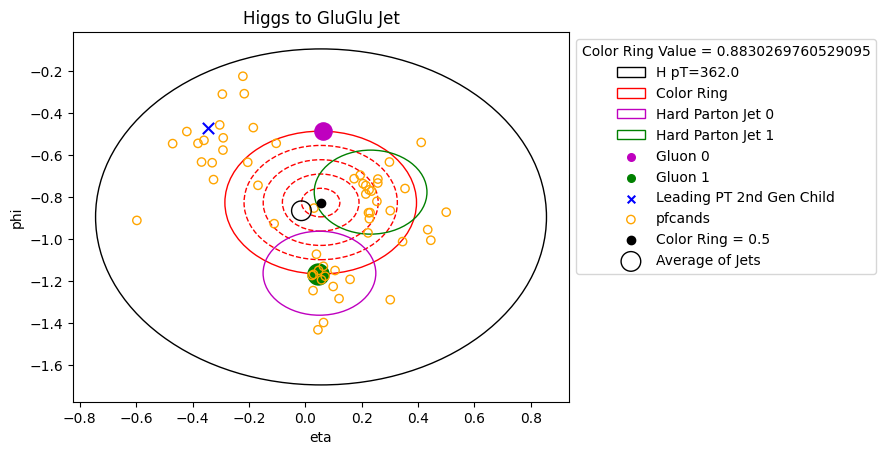

In [412]:
# Gen Particles and children, including the gluon
fig,ax = plt.subplots()
ax.add_patch(plt.Circle((higgs.eta, higgs.phi), 0.8, facecolor="none", edgecolor="k", label=f"H pT={higgs.pt}"))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.6*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.4*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.2*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((hp0_eta, hp0_phi), 0.2, facecolor='none', edgecolor='m', label='Hard Parton Jet 0'))
ax.add_patch(plt.Circle((hp1_eta, hp1_phi), 0.2, facecolor='none', edgecolor='g', label='Hard Parton Jet 1'))
ax.scatter(higgs.children[0].eta, higgs.children[0].phi, 
           s=higgs.children[0].pt, 
           label="Gluon 0", color='m')
ax.scatter(higgs.children[1].eta, higgs.children[1].phi, 
           s=higgs.children[1].pt, 
           label="Gluon 1", color='g')
# ax.scatter(higgs.children[0].children.eta, higgs.children[0].children.phi, 
#            s=higgs.children[0].children.pt, 
#            marker="x", label="Child 0 children", color='m')
# ax.scatter(higgs.children[1].children.eta, higgs.children[1].children.phi, 
#            s=higgs.children[1].children.pt, 
#            marker="x", label="Child 1 children", color='g')
ax.scatter(largest_eta, largest_phi, 
           s=largest_pt, 
           marker="x", color='b', label='Leading PT 2nd Gen Child')
# ax.scatter(glu_eta, glu_phi, 
#            #s=glu_pt, 
#            marker="o", color='k', label='Emitted Gluon',facecolors='none')
ax.scatter(pfcands_eta, pfcands_phi, 
#            #s=glu_pt, 
            marker="o", color='orange', label='pfcands',facecolors='none')
ax.scatter(midpoint_eta, midpoint_phi, label='Color Ring = 0.5', color='k')
ax.scatter(se_eta, se_phi, 
           s= 200,
           marker="o", color='k', label='Average of Jets',facecolors='none')
lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(all_vals['cr'][cut][choose][0]))
lgnd.legend_handles[1]._sizes = [30]
lgnd.legend_handles[2]._sizes = [30]
lgnd.legend_handles[3]._sizes = [30]
lgnd.legend_handles[4]._sizes = [30]
lgnd.legend_handles[5]._sizes = [30]
lgnd.legend_handles[6]._sizes = [30]
plt.xlabel('eta')
plt.ylabel('phi')
plt.title('Higgs to GluGlu Jet')

In [397]:
midpoint_eta = (hp0_weighted_eta + hp1_weighted_eta)/2
midpoint_phi = (hp0_weighted_phi + hp1_weighted_phi)/2
radius = math.sqrt((hp0_weighted_eta - hp1_weighted_eta)**2 + (hp0_weighted_phi - hp1_weighted_phi)**2)/2

In [398]:
cut2 = (higgs_fatjet.constituents.pf.pt > 5)
weighted_pf_eta = (higgs_fatjet.constituents.pf.eta[cut2] 
                   * (higgs_fatjet.constituents.pf.pt[cut2]/(ak.sum(higgs_fatjet.constituents.pf.pt[cut2], axis=2)-ak.max(higgs_fatjet.constituents.pf.pt[cut2], axis=2)))
                  )
weighted_pf_phi = (higgs_fatjet.constituents.pf.phi[cut2] 
                   * (higgs_fatjet.constituents.pf.pt[cut2]/(ak.sum(higgs_fatjet.constituents.pf.pt[cut2], axis=2)-ak.max(higgs_fatjet.constituents.pf.pt[cut2], axis=2)))
                  )

pick_eta = weighted_pf_eta[all_vals['idx'][cut][choose][0]][0]
pick_phi = weighted_pf_phi[all_vals['idx'][cut][choose][0]][0]

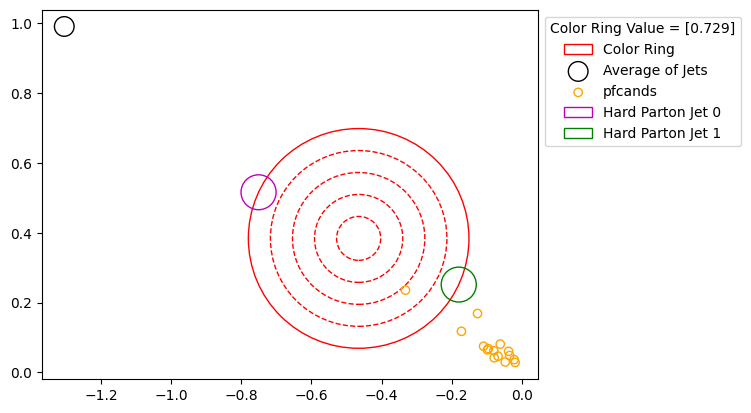

In [399]:
#First gen children and the selected subjets
fig,ax = plt.subplots()
# ax.add_patch(plt.Circle((higgs.eta, higgs.phi), 0.8, facecolor="none", edgecolor="k", label="AK8 Jet"))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), radius, facecolor='none', edgecolor='r', label='Color Ring'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.8*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.6*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.4*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.add_patch(plt.Circle((midpoint_eta, midpoint_phi), 0.2*radius, facecolor='none', edgecolor='r', linestyle='--'))
ax.scatter(se_eta, se_phi, 
           s= 200,
           marker="o", color='k', label='Average of Jets',facecolors='none')
ax.scatter(pick_eta, pick_phi, 
            #s=10, 
            marker="o", color='orange', label='pfcands',facecolors='none')
ax.add_patch(plt.Circle((hp0_weighted_eta, hp0_weighted_phi), 0.05, facecolor='none', edgecolor='m', label='Hard Parton Jet 0'))
ax.add_patch(plt.Circle((hp1_weighted_eta, hp1_weighted_phi), 0.05, facecolor='none', edgecolor='g', label='Hard Parton Jet 1'))
# ax.add_patch(plt.Circle((se_eta, se_phi), 0.2, facecolor='none', edgecolor='k', label='Soft Emission Jet'))
lgnd = ax.legend(bbox_to_anchor=(1,1), title='Color Ring Value = ' + str(all_vals['cr'][cut][choose]))

In [376]:
ak.max(higgs_fatjet.constituents.pf.pt, axis=2)

<Array [[31.6], [], [29.1], ..., [54.8], [45.8]] type='3000 * var * ?float32'>